# Random Forest ile Enerji Tüketimi Tahmini
Bu not defteri, elektrikli araçların enerji tüketimini tahmin etmek için bir Random Forest Regresyon modeli oluşturma sürecini detaylandırmaktadır.


### Neden Random Forest?

* **Non-Linearty (Doğrusal Olmayan İlişkiler):** Random Forest, araç hızı, ivme ve yol eğimi gibi karmaşık, doğrusal olmayan ilişkileri başarıyla yakalayabilir.
* **Overfitting Riskini Azaltma:** Her bir karar ağacı, veri setinin rastgele seçilmiş bir alt kümesi üzerinde eğitildiği için modelin aşırı uyum (overfitting) riski azalır.
* **Özellik Önem Derecesi Belirleme:** Model, enerji tüketimini en çok etkileyen faktörlerin hangileri olduğunu belirlememize olanak tanır. Bu, veri analizi ve model yorumlama için kritik bir adımdır.

### 1. Kütüphaneleri Yükleme

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### 2. Veri Yükleme ve Ön İnceleme


In [2]:
df = pd.read_csv('final_training_data.csv')
df.head(3)

,timestamp,vehicle_id,speed_kmh,lat,lon,z,acceleration,mass_kg,soc_pc,energy_consumption,...,device.battery.capacity,frontSurfaceArea,recuperationEfficiency,maximumPower,device.battery.maximumChargeRate,rollDragCoefficient,rotatingMass,radialDragCoefficient,dist_m,slope_pct
0,2,veh1,0.000,39.751093,30.502114,825.839847,0.00,1916.0,91.741386,0.00,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,NaN,NaN
1,3,veh1,13.824,39.751061,30.502096,825.898326,3.84,1916.0,91.736124,4.93,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,3.842938,1.521728
2,4,veh1,27.648,39.750998,30.502060,826.015284,3.84,1916.0,91.721126,14.04,...,93684.0,2.45,0.93,187368.0,138421.0,0.01,38.0,0.445,7.685875,1.521728


In [3]:
print("Orijinal veri boyutu:", df.shape)
print("Araç sayısı:", df['vehicle_id'].nunique())
print("Eksik veri durumu:")
print(df.isnull().sum())

Orijinal veri boyutu: (481411, 25)
Araç sayısı: 300
Eksik veri durumu:
timestamp                                0
vehicle_id                               0
speed_kmh                                0
lat                                      0
lon                                      0
z                                        0
acceleration                             0
mass_kg                                  0
soc_pc                                   0
energy_consumption                       0
accel                                    0
decel                                    0
propulsionEfficiency                     0
airDragCoefficient                       0
constantPowerIntake                      0
device.battery.capacity                  0
frontSurfaceArea                         0
recuperationEfficiency                   0
maximumPower                             0
device.battery.maximumChargeRate         0
rollDragCoefficient                      0
rotatingMass              

In [4]:
# 'dist_m' sütunundaki NaN değerleri 0 ile doldurur
df['dist_m'] = df['dist_m'].fillna(0)

# slope_pct 50'den küçük ve -50'den büyük olan satırları filtreler
df = df[(df["slope_pct"] < 50) & (df["slope_pct"] > -50)]

# 'slope_pct' sütunundaki NaN değerleri 0 ile doldurur
df['slope_pct'] = df['slope_pct'].fillna(0)


In [5]:
print(df.isnull().sum())

timestamp                           0
vehicle_id                          0
speed_kmh                           0
lat                                 0
lon                                 0
z                                   0
acceleration                        0
mass_kg                             0
soc_pc                              0
energy_consumption                  0
accel                               0
decel                               0
propulsionEfficiency                0
airDragCoefficient                  0
constantPowerIntake                 0
device.battery.capacity             0
frontSurfaceArea                    0
recuperationEfficiency              0
maximumPower                        0
device.battery.maximumChargeRate    0
rollDragCoefficient                 0
rotatingMass                        0
radialDragCoefficient               0
dist_m                              0
slope_pct                           0
dtype: int64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360190 entries, 1 to 481410
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   timestamp                         360190 non-null  int64  
 1   vehicle_id                        360190 non-null  object 
 2   speed_kmh                         360190 non-null  float64
 3   lat                               360190 non-null  float64
 4   lon                               360190 non-null  float64
 5   z                                 360190 non-null  float64
 6   acceleration                      360190 non-null  float64
 7   mass_kg                           360190 non-null  float64
 8   soc_pc                            360190 non-null  float64
 9   energy_consumption                360190 non-null  float64
 10  accel                             360190 non-null  float64
 11  decel                             360190 non-null  float6

### 3. Özellik Mühendisliği (Feature Engineering)


* **İvme Ayrımı:** İvme değeri (acceleration) pozitif ve negatif olmak üzere iki ayrı sütuna (acc_pos, acc_neg) ayrılır. Bu, pozitif ivmenin (hızlanma) enerji tüketimini artırdığı, negatif ivmenin (yavaşlama/fren) ise rejeneratif enerji kazanımı sağlayabileceği bilgisini modele daha açık bir şekilde iletmemizi sağlar.

In [7]:
df["acc_pos"] = df["acceleration"].clip(lower=0)
df["acc_neg"] = (-df["acceleration"]).clip(lower=0)
df["slope_pct_pos"] = df["slope_pct"].clip(lower=0)
df["slope_pct_neg"] = (-df["slope_pct"]).clip(lower=0)

* **Hız Birimi Dönüşümü:** Hız (speed_kmh) birimi km/h'den m/s'ye (speed_ms) dönüştürülür. Fiziksel hesaplamalar için daha uygun bir birimdir.

* **Aerodinamik Katsayı (CdA):** airDragCoefficient ve frontSurfaceArea sütunları birleştirilerek CdA adında yeni bir özellik oluşturulur. Bu iki değerin çarpımı, aerodinamik direncin doğrudan bir göstergesidir.

In [8]:
# Hız: m/s
df["speed_ms"] = df["speed_kmh"] / 3.6

# Aerodinamik: Cd * A
df["CdA"] = df["airDragCoefficient"] * df["frontSurfaceArea"]


### 4. Gereksiz Sütunları Kaldırma


In [9]:
columns_to_drop = [
    'timestamp',  # Zaman bilgisi
    'lat', 'lon', 'z',  # GPS koordinatları
    'accel','decel', 'acceleration',
    'speed_kmh',
    'device.battery.capacity',
    'airDragCoefficient', 'frontSurfaceArea',
    'slope_pct'

]
df = df.drop(columns=columns_to_drop)
df.shape

(360190, 19)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360190 entries, 1 to 481410
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   vehicle_id                        360190 non-null  object 
 1   mass_kg                           360190 non-null  float64
 2   soc_pc                            360190 non-null  float64
 3   energy_consumption                360190 non-null  float64
 4   propulsionEfficiency              360190 non-null  float64
 5   constantPowerIntake               360190 non-null  float64
 6   recuperationEfficiency            360190 non-null  float64
 7   maximumPower                      360190 non-null  float64
 8   device.battery.maximumChargeRate  360190 non-null  float64
 9   rollDragCoefficient               360190 non-null  float64
 10  rotatingMass                      360190 non-null  float64
 11  radialDragCoefficient             360190 non-null  float6

### 5. Veriyi Eğitim, Doğrulama ve Test Setlerine Ayırma


Aynı araca ait verilerin farklı setlere karışmasını engellemek için GroupShuffleSplit kullanılarak veriler eğitim, doğrulama ve test setlerine ayrılır. Bu sayede veri sızıntısının (data leakage) önüne geçilmiş olur.

In [11]:

groups = df["vehicle_id"]

X = df.drop(columns=[ "vehicle_id", "energy_consumption"])
y = df["energy_consumption"]


def group_split(X, y, groups, test_size=0.15, val_size=0.15, rs=42):
    """
    X, y ve groups'u alır; önce TEST setini, sonra kalan içinden VALIDATION setini ayırır.
    NOT: Aynı 'vehicle_id'ye ait TÜM satırlar ya train/val tarafında kalır ya da testte olur;
         asla bir araca ait satırlar birden fazla parçaya bölünmez.
    """
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=rs)
    i_tr, i_te = next(gss.split(X, y, groups))
    gss2 = GroupShuffleSplit(n_splits=1, test_size=val_size/(1-test_size), random_state=rs)
    j_tr, j_val = next(gss2.split(X.iloc[i_tr], y.iloc[i_tr], groups.iloc[i_tr]))
    tr_idx = X.iloc[i_tr].index[j_tr]; val_idx = X.iloc[i_tr].index[j_val]; te_idx = X.index[i_te]
    return tr_idx, val_idx, te_idx

train_idx, val_idx, test_idx = group_split(X, y, groups)
X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_val,   y_val   = X.loc[val_idx],   y.loc[val_idx]
X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]
print(f"Split -> train:{len(train_idx)}, val:{len(val_idx)}, test:{len(test_idx)}")
print("\nEğitim için kullanılacak özelliklerin bilgi özeti:")
X_train.info()

Split -> train:258130, val:53057, test:49003

Eğitim için kullanılacak özelliklerin bilgi özeti:
<class 'pandas.core.frame.DataFrame'>
Index: 258130 entries, 1 to 481410
Data columns (total 17 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   mass_kg                           258130 non-null  float64
 1   soc_pc                            258130 non-null  float64
 2   propulsionEfficiency              258130 non-null  float64
 3   constantPowerIntake               258130 non-null  float64
 4   recuperationEfficiency            258130 non-null  float64
 5   maximumPower                      258130 non-null  float64
 6   device.battery.maximumChargeRate  258130 non-null  float64
 7   rollDragCoefficient               258130 non-null  float64
 8   rotatingMass                      258130 non-null  float64
 9   radialDragCoefficient             258130 non-null  float64
 10  dist_m                  

### 6. Random Forest Modelini Eğitme


In [12]:
rf_model = RandomForestRegressor(
    n_estimators=100, #Ormandaki ağaç sayısı
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print("\nRandom Forest modeli eğitiliyor...")
rf_model.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")



Random Forest modeli eğitiliyor...
Model eğitimi tamamlandı.


### 7. Model Değerlendirme

Eğitilen model, doğrulama ve test setleri üzerinde tahminler yaparak performansı değerlendirilir. Mean Squared Error (MSE), Root Mean Squared Error (RMSE) ve R-kare (R²) metrikleri kullanılarak modelin başarısı ölçülür.

In [13]:
# Doğrulama ve Test setlerinde tahminler yapılır
y_val_pred = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

In [14]:
from sklearn.metrics import mean_absolute_error

mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)



In [15]:
print(f"Validation -> MSE: {mse_val:.4f} | RMSE: {rmse_val:.4f} | MAE: {mae_val:.4f} | R²: {r2_val:.4f}")
print(f"Test       -> MSE: {mse_test:.4f} | RMSE: {rmse_test:.4f} | MAE: {mae_test:.4f} | R²: {r2_test:.4f}")

Validation -> MSE: 9.0440 | RMSE: 3.0073 | MAE: 1.6049 | R²: 0.9520
Test       -> MSE: 9.2826 | RMSE: 3.0467 | MAE: 1.6925 | R²: 0.9608


### 8. Tahmin ve Gerçek Değerleri Karşılaştırma


Modelin tahminlerinin ne kadar isabetli olduğunu görsel olarak anlamak için doğrulama ve test setindeki gerçek değerler ile tahmin edilen değerler saçılım grafikleri (scatter plot) ile karşılaştırılır. Kırmızı kesik çizgi, ideal tahminlerin (tahmin = gerçek) olduğu yeri gösterir. Noktaların bu çizgiye ne kadar yakın olduğu, modelin performansının bir göstergesidir.

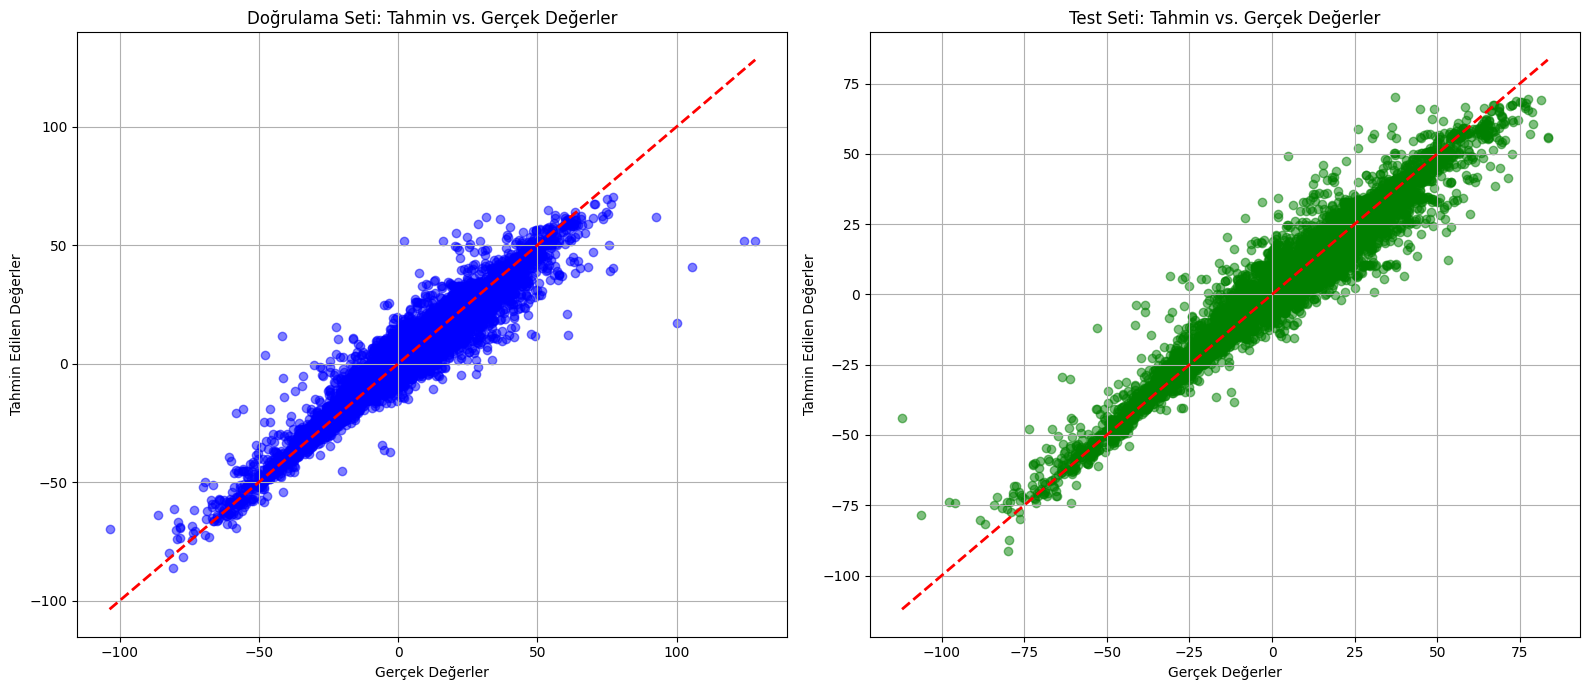

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Doğrulama Seti Grafiği
ax1.scatter(y_val, y_val_pred, alpha=0.5, color='b')
min_val = min(y_val.min(), y_val_pred.min())
max_val = max(y_val.max(), y_val_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
ax1.set_title('Doğrulama Seti: Tahmin vs. Gerçek Değerler')
ax1.set_xlabel('Gerçek Değerler')
ax1.set_ylabel('Tahmin Edilen Değerler')
ax1.grid(True)

# Test Seti Grafiği
ax2.scatter(y_test, y_test_pred, alpha=0.5, color='g')
min_test = min(y_test.min(), y_test_pred.min())
max_test = max(y_test.max(), y_test_pred.max())
ax2.plot([min_test, max_test], [min_test, max_test], 'r--', lw=2)
ax2.set_title('Test Seti: Tahmin vs. Gerçek Değerler')
ax2.set_xlabel('Gerçek Değerler')
ax2.set_ylabel('Tahmin Edilen Değerler')
ax2.grid(True)

plt.tight_layout()
plt.show()

### 9. Özellik Önem Derecesini Analiz Etme


Eğitilen modelin hangi özelliklere daha fazla ağırlık verdiğini görmek için özellik önem dereceleri incelenir ve görselleştirilir. Bu, modelin tahminlerinin arkasındaki mantığı anlamamıza yardımcı olur.


--- Özellik Önem Dereceleri ---
acc_neg                             0.526753
acc_pos                             0.234314
dist_m                              0.099303
speed_ms                            0.054991
slope_pct_pos                       0.048962
slope_pct_neg                       0.021974
maximumPower                        0.001787
rotatingMass                        0.001562
recuperationEfficiency              0.001505
soc_pc                              0.001451
constantPowerIntake                 0.001392
device.battery.maximumChargeRate    0.001387
radialDragCoefficient               0.001367
mass_kg                             0.001345
CdA                                 0.001278
propulsionEfficiency                0.000324
rollDragCoefficient                 0.000306
dtype: float64


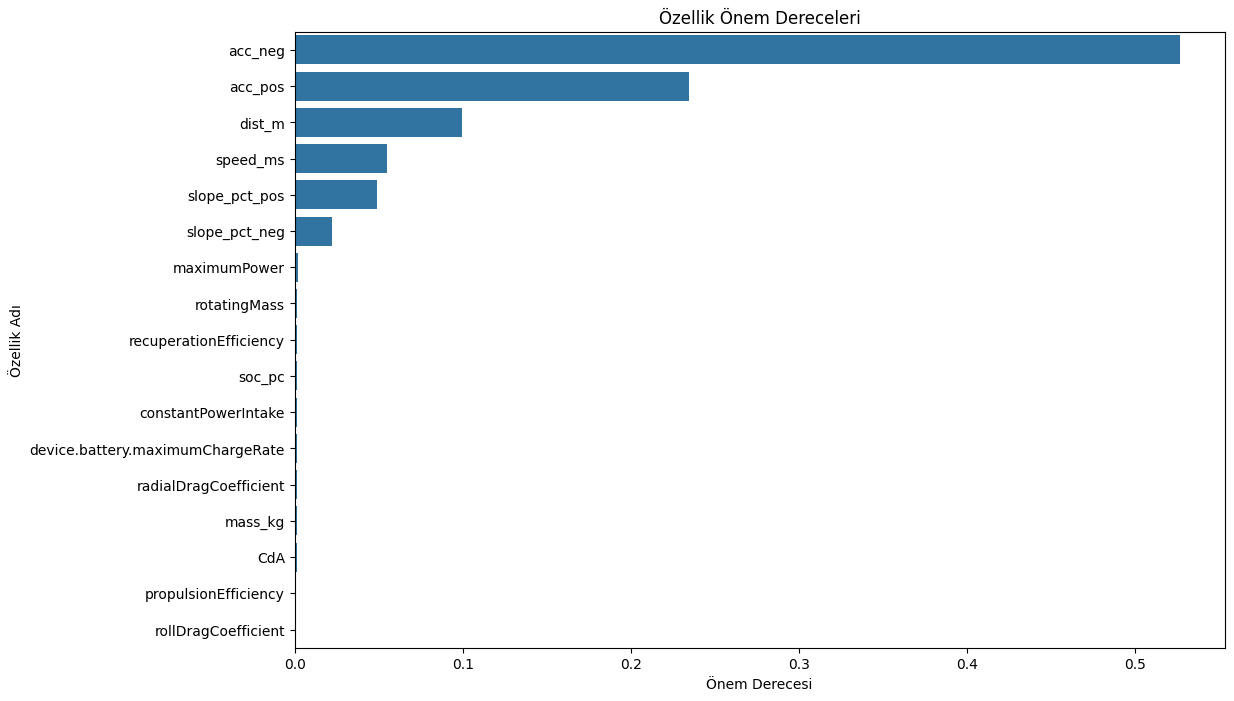

In [17]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n--- Özellik Önem Dereceleri ---")
print(feature_importances)

# Özellik önem derecelerini görselleştirme
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Özellik Önem Dereceleri')
plt.xlabel('Önem Derecesi')
plt.ylabel('Özellik Adı')
plt.show()

### 10. Shapley Additive exPlanations (SHAP)

In [18]:
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_val)

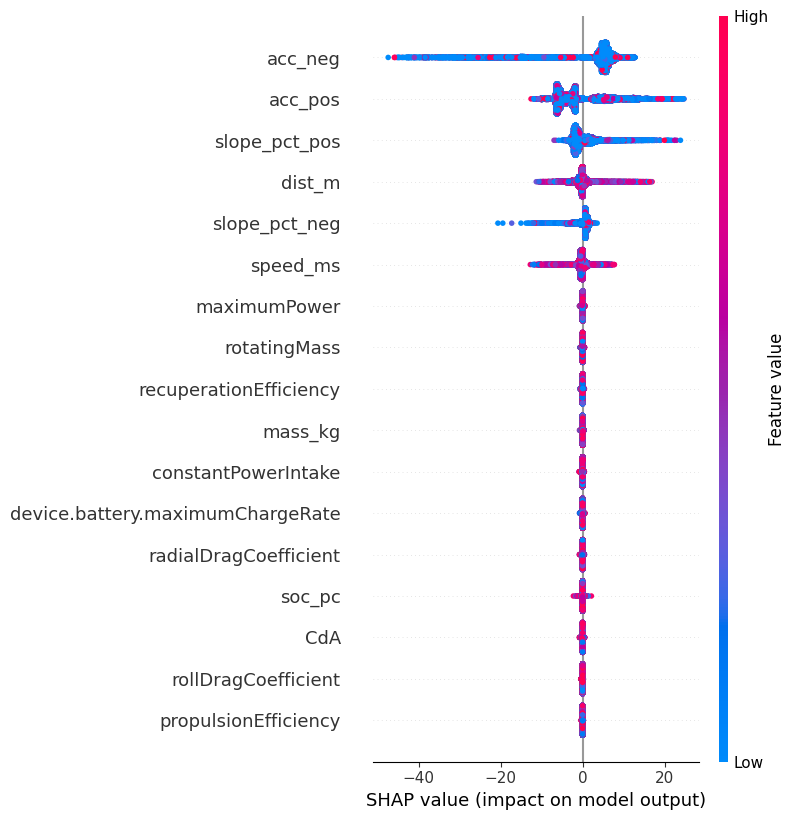

In [19]:
# X_test ile shap_values boyutlarını eşitle
shap_values = shap_values[:len(X_test)]
shap.summary_plot(shap_values, X_test)
